# Precipitation histograms in new WoFS simulations

## Setup

In [2]:
# Import statements
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics.progress import ProgressBar

from matplotlib.ticker import FuncFormatter

### New WoFS

In [3]:
# Create function to read in WoFS output
def get_wofs_all(init: int) -> xr.Dataset:
    loaded = xr.open_mfdataset(
        "/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc".format(init=init),
        combine="nested",
        concat_dim="time",
        chunks="auto",
    )
    if init < 6:
        loaded["time"] = xr.cftime_range(
            "2021-09-02 {start:02d}:00:00".format(start=init),
            "2021-09-02 {end:02d}:00:00".format(end=init + 6),
            freq="5min",
        )
    elif (init >= 6):
        loaded["time"] = xr.cftime_range(
            "2021-09-01 {start:02d}:00:00".format(start=init),
            "2021-09-02 {end:02d}:00:00".format(end=init-24 + 6),
            freq="5min",
        )
    return(loaded)

In [4]:
# Read in 20 - 01 UTC initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23,0,1]]

# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"], dims="init")
init = init.assign_coords({"init": init})

# Concat list of Datasets
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    rain_all = xr.concat([w.rain for w in wofs_all], dim=init).chunk("auto")

In [5]:
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

In [6]:
# Set desired latitude and longitude
# Central Park: 40.7826° N, 73.9656° W
nyc_lat, nyc_lon = 40.7826, -73.9656

# Calculate the Euclidean distance between lat and lon values and the desired point
distance = np.sqrt((lat - nyc_lat) ** 2 + (lon - nyc_lon) ** 2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["NY", "NX"])
lat_ind, lon_ind = int(nyc_inds["NY"]), int(nyc_inds["NX"])

In [8]:
# Calculate 01-02 UTC rainfall
rain_0102 = (
    rain_all.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .chunk("auto")
)
rain_0102_point = rain_0102.isel(lat=lat_ind, lon=lon_ind).squeeze()
rain_0102_48km = (
    rain_0102.isel(
        lat=slice(lat_ind - 8, lat_ind + 8), lon=slice(lon_ind - 8, lon_ind + 8)
    )
    .mean(dim=["lat", "lon"])
    .squeeze()
)

### Old WoFS

In [11]:
def load_data(init: str, keyword: str) -> xr.Dataset:

    # Note that this function depends on a consistent file structure so if you
    # change that, you'll need to change this function.
    # First, determine starting date
    start_date = "2021-09-02" if init in ["00Z", "01Z"] else "2021-09-01"
    new_dates = xr.date_range(
        start=start_date + " " + init[:-1] + ":00:00",
        end="2021-09-02 " + str((int(init[:-1]) + 6) % 24).zfill(2) + ":00:00",
        freq="5min",
        use_cftime=True,
    )

    # read in data
    data = xr.open_mfdataset(
        "/mnt/drive2/wof-runs/post-processed/"
        + init
        + "/wofs_"
        + keyword.upper()
        + "*.nc",
        concat_dim="time",
        combine="nested",
    )
    data["time"] = new_dates
    return data

ens = [load_data(i, "ens") for i in ["20Z", "21Z", "22Z", "23Z", "00Z", "01Z"]]
ens = [e.assign_coords(lat=e.lat, lon=e.lon, ne=e.ne) for e in ens]

# concat
ens = xr.concat(ens, dim=init).chunk({"init": 1, "time": -1})

In [14]:
old_rain_0102 = (
    ens.rain.sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .chunk("auto")
)
old_rain_0102_point = old_rain_0102.isel(lat=lat_ind, lon=lon_ind).squeeze()
old_rain_0102_48km = (
    old_rain_0102.isel(
        lat=slice(lat_ind - 8, lat_ind + 8), lon=slice(lon_ind - 8, lon_ind + 8)
    )
    .mean(dim=["lat", "lon"])
    .squeeze()
)

In [26]:
# Start with averages
with ProgressBar():
    old_rain_0102_48km = old_rain_0102_48km.compute()
    rain_0102_48km = rain_0102_48km.compute()

[########################################] | 100% Completed | 29.56 s
[########################################] | 100% Completed | 11.86 s


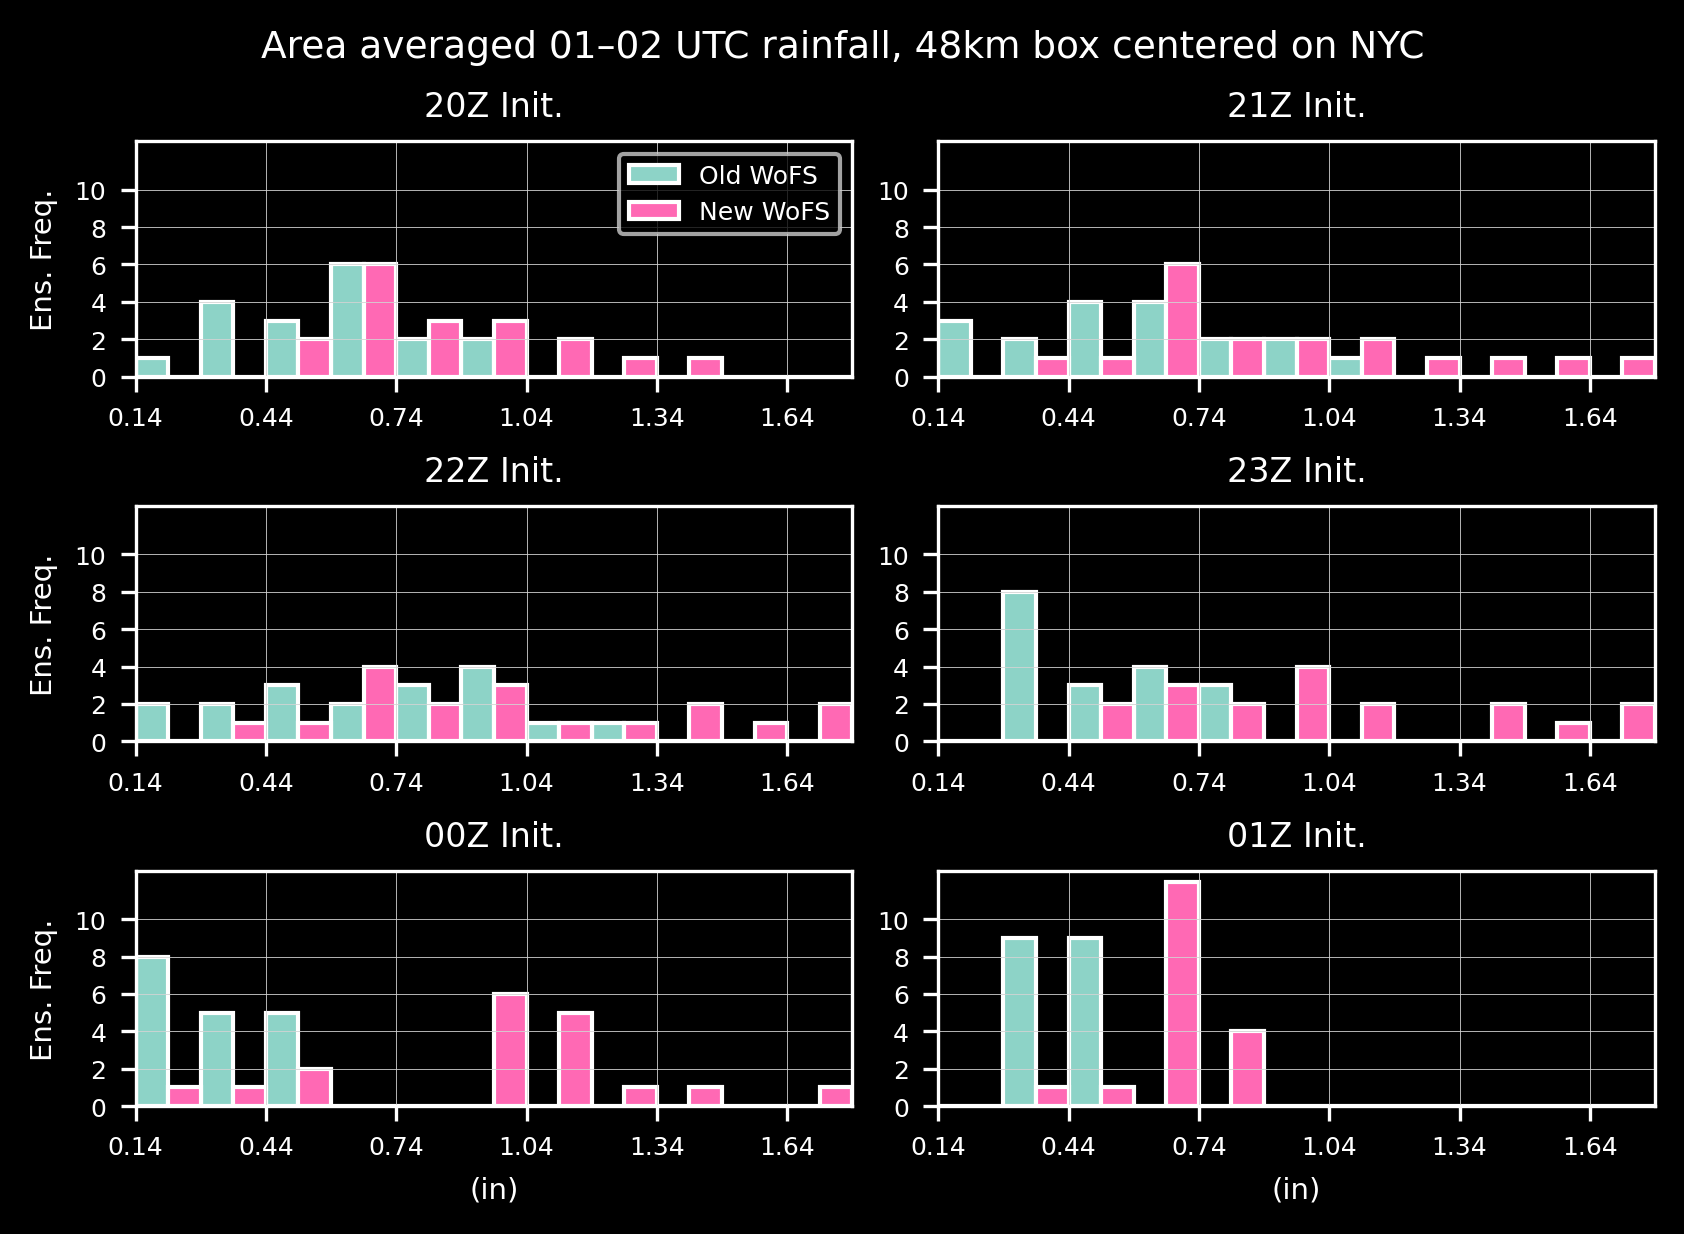

In [69]:
plt.style.use("dark_background")
bins = np.histogram_bin_edges(
    np.concat([old_rain_0102_48km.values, rain_0102_48km.values]), bins="auto"
)

# Make a list of titles
titles = ["20Z Init.", "21Z Init.", "22Z Init.", "23Z Init.", "00Z Init.", "01Z Init."]

# Function to format the x-tick labels to two decimal points
def two_decimal_formatter(x, pos):
    return f"{x:.2f}"

# Make a 3 x 2 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    sharex=True,
    sharey=True,
    dpi=300,
    figsize=(5.5, 4),
    layout="constrained",
)

# Width for the bars in the histograms
bar_width = (bins[1] - bins[0]) / 2

# Loop through each initialization
for i, ax in enumerate(axes.flatten()):
    # Extract the data for the current initialization
    old_data = old_rain_0102_48km.isel(init=i).values
    new_data = rain_0102_48km.isel(init=i).values

    # Compute the histogram
    old_hist, _ = np.histogram(old_data, bins=bins)
    new_hist, _ = np.histogram(new_data, bins=bins)

    # Plot the histograms
    ax.bar(
        bins[:-1],
        old_hist,
        width=bar_width,
        align="edge",
        edgecolor="white",
        label="Old WoFS",
    )
    ax.bar(
        bins[:-1] + bar_width,
        new_hist,
        width=bar_width,
        align="edge",
        edgecolor="white",
        color="hotpink",
        label="New WoFS",
    )

    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.tick_params(axis="both", labelsize=6)
    ax.set_xticks(bins[::2])
    ax.set_yticks(range(0,12,2))
    ax.yaxis.set_tick_params(which="both", labelleft=True)
    ax.grid(color="lightgray", linewidth=0.2)
    ax.set_title(titles[i], fontsize=8)
    ax.set_xlabel("")

    # Set the x-axis formatter to round to two decimal points
    ax.xaxis.set_major_formatter(FuncFormatter(two_decimal_formatter))

    if i % 2 == 0:
        ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set the x-axis labels for the bottom row of plots
axes[2, 1].set_xlabel("(in)", fontsize=7)
axes[2, 0].set_xlabel("(in)", fontsize=7)

# Set the x-axis limit
plt.xlim(bins.min(), bins.max())

# Add a legend to the plot
axes[0, 0].legend(fontsize=6)

# Set the overall title of the figure
plt.suptitle("Area averaged 01–02 UTC rainfall, 48km box centered on NYC", fontsize=9)

# Show the plot
plt.show()

In [70]:
# Start with averages
with ProgressBar():
    old_rain_0102_point = old_rain_0102_point.compute()
    rain_0102_point = rain_0102_point.compute()

[########################################] | 100% Completed | 29.04 s
[########################################] | 100% Completed | 10.64 s


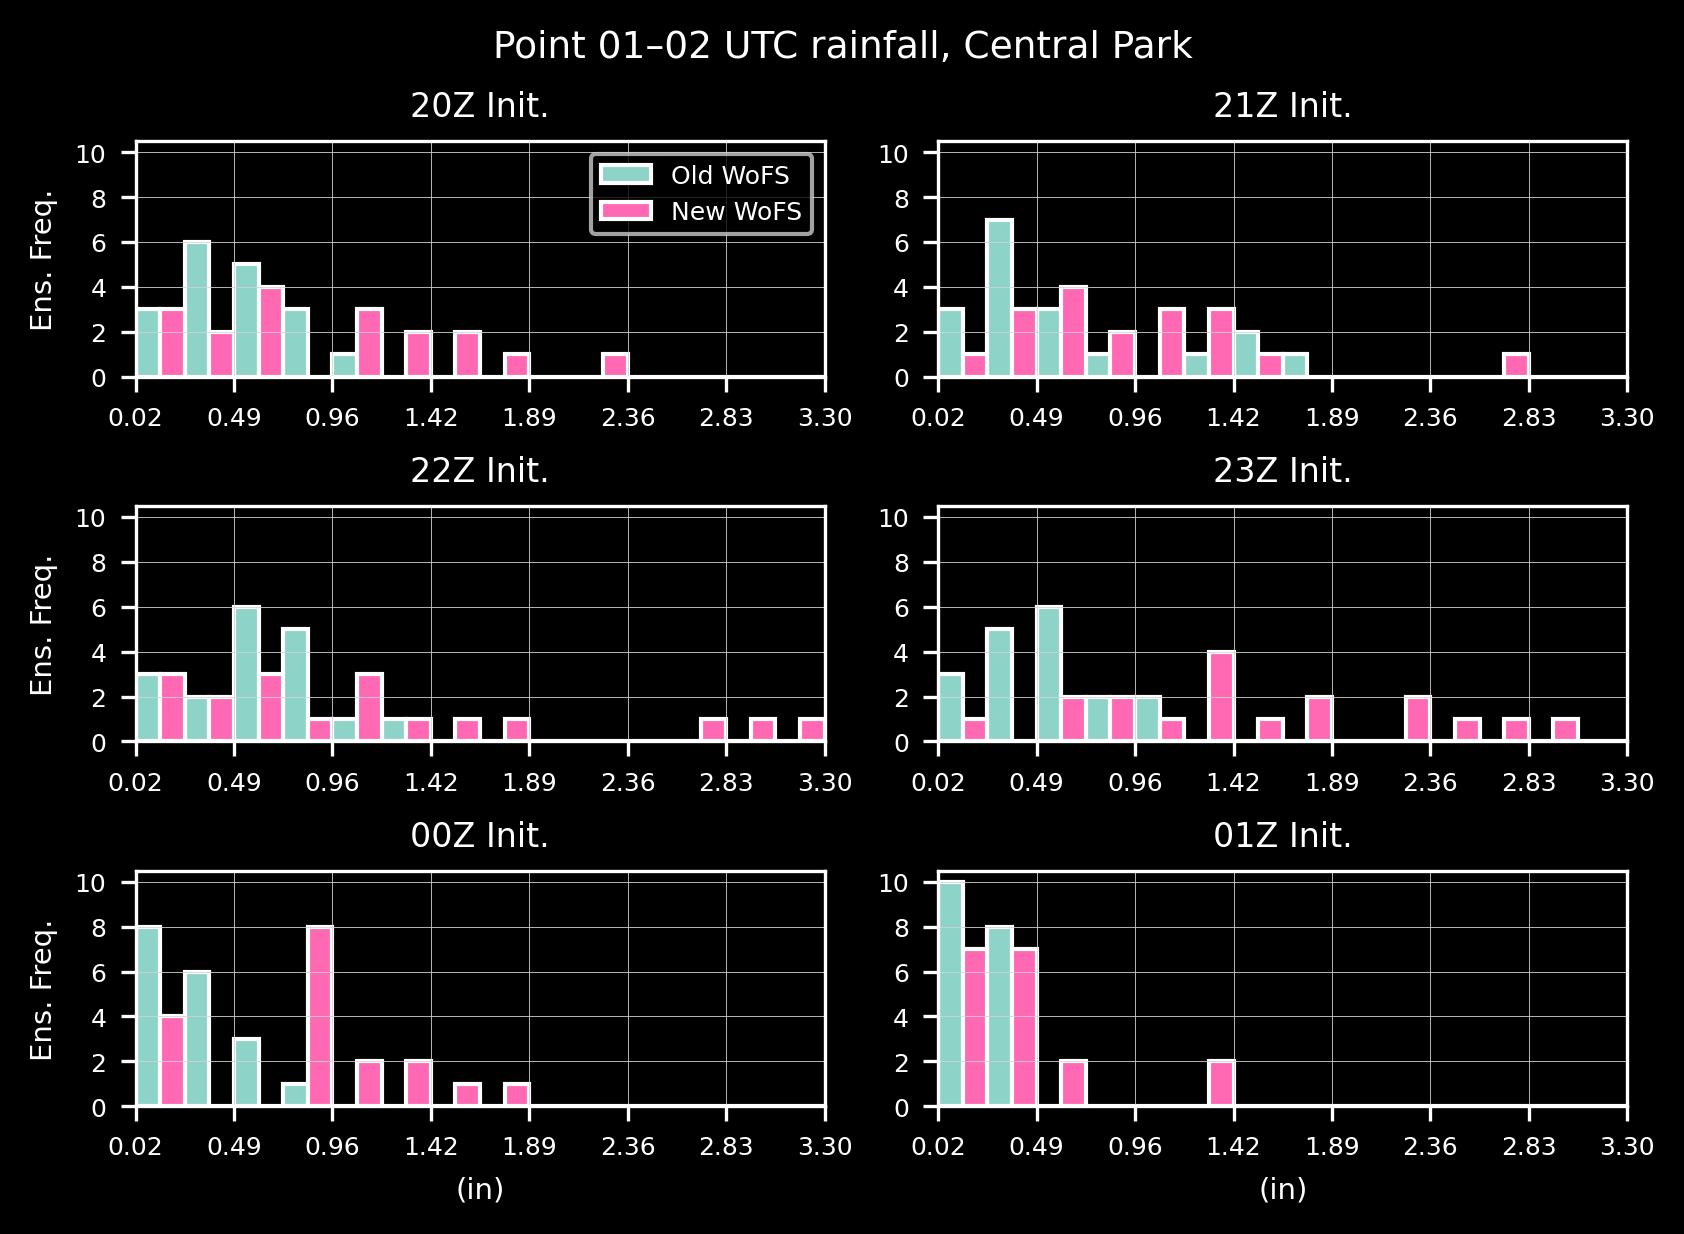

In [71]:
plt.style.use("dark_background")
bins = np.histogram_bin_edges(
    np.concat([old_rain_0102_point.values, rain_0102_point.values]), bins="auto"
)

# Make a list of titles
titles = ["20Z Init.", "21Z Init.", "22Z Init.", "23Z Init.", "00Z Init.", "01Z Init."]

# Function to format the x-tick labels to two decimal points
def two_decimal_formatter(x, pos):
    return f"{x:.2f}"

# Make a 3 x 2 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    sharex=True,
    sharey=True,
    dpi=300,
    figsize=(5.5, 4),
    layout="constrained",
)

# Width for the bars in the histograms
bar_width = (bins[1] - bins[0]) / 2

# Loop through each initialization
for i, ax in enumerate(axes.flatten()):
    # Extract the data for the current initialization
    old_data = old_rain_0102_point.isel(init=i).values
    new_data = rain_0102_point.isel(init=i).values

    # Compute the histogram
    old_hist, _ = np.histogram(old_data, bins=bins)
    new_hist, _ = np.histogram(new_data, bins=bins)

    # Plot the histograms
    ax.bar(
        bins[:-1],
        old_hist,
        width=bar_width,
        align="edge",
        edgecolor="white",
        label="Old WoFS",
    )
    ax.bar(
        bins[:-1] + bar_width,
        new_hist,
        width=bar_width,
        align="edge",
        edgecolor="white",
        color="hotpink",
        label="New WoFS",
    )

    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.tick_params(axis="both", labelsize=6)
    ax.set_xticks(bins[::2])
    ax.set_yticks(range(0,12,2))
    ax.yaxis.set_tick_params(which="both", labelleft=True)
    ax.grid(color="lightgray", linewidth=0.2)
    ax.set_title(titles[i], fontsize=8)
    ax.set_xlabel("")

    # Set the x-axis formatter to round to two decimal points
    ax.xaxis.set_major_formatter(FuncFormatter(two_decimal_formatter))

    if i % 2 == 0:
        ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set the x-axis labels for the bottom row of plots
axes[2, 1].set_xlabel("(in)", fontsize=7)
axes[2, 0].set_xlabel("(in)", fontsize=7)

# Set the x-axis limit
plt.xlim(bins.min(), bins.max())

# Add a legend to the plot
axes[0, 0].legend(fontsize=6)

# Set the overall title of the figure
plt.suptitle("Point 01–02 UTC rainfall, Central Park", fontsize=9)

# Show the plot
plt.show()

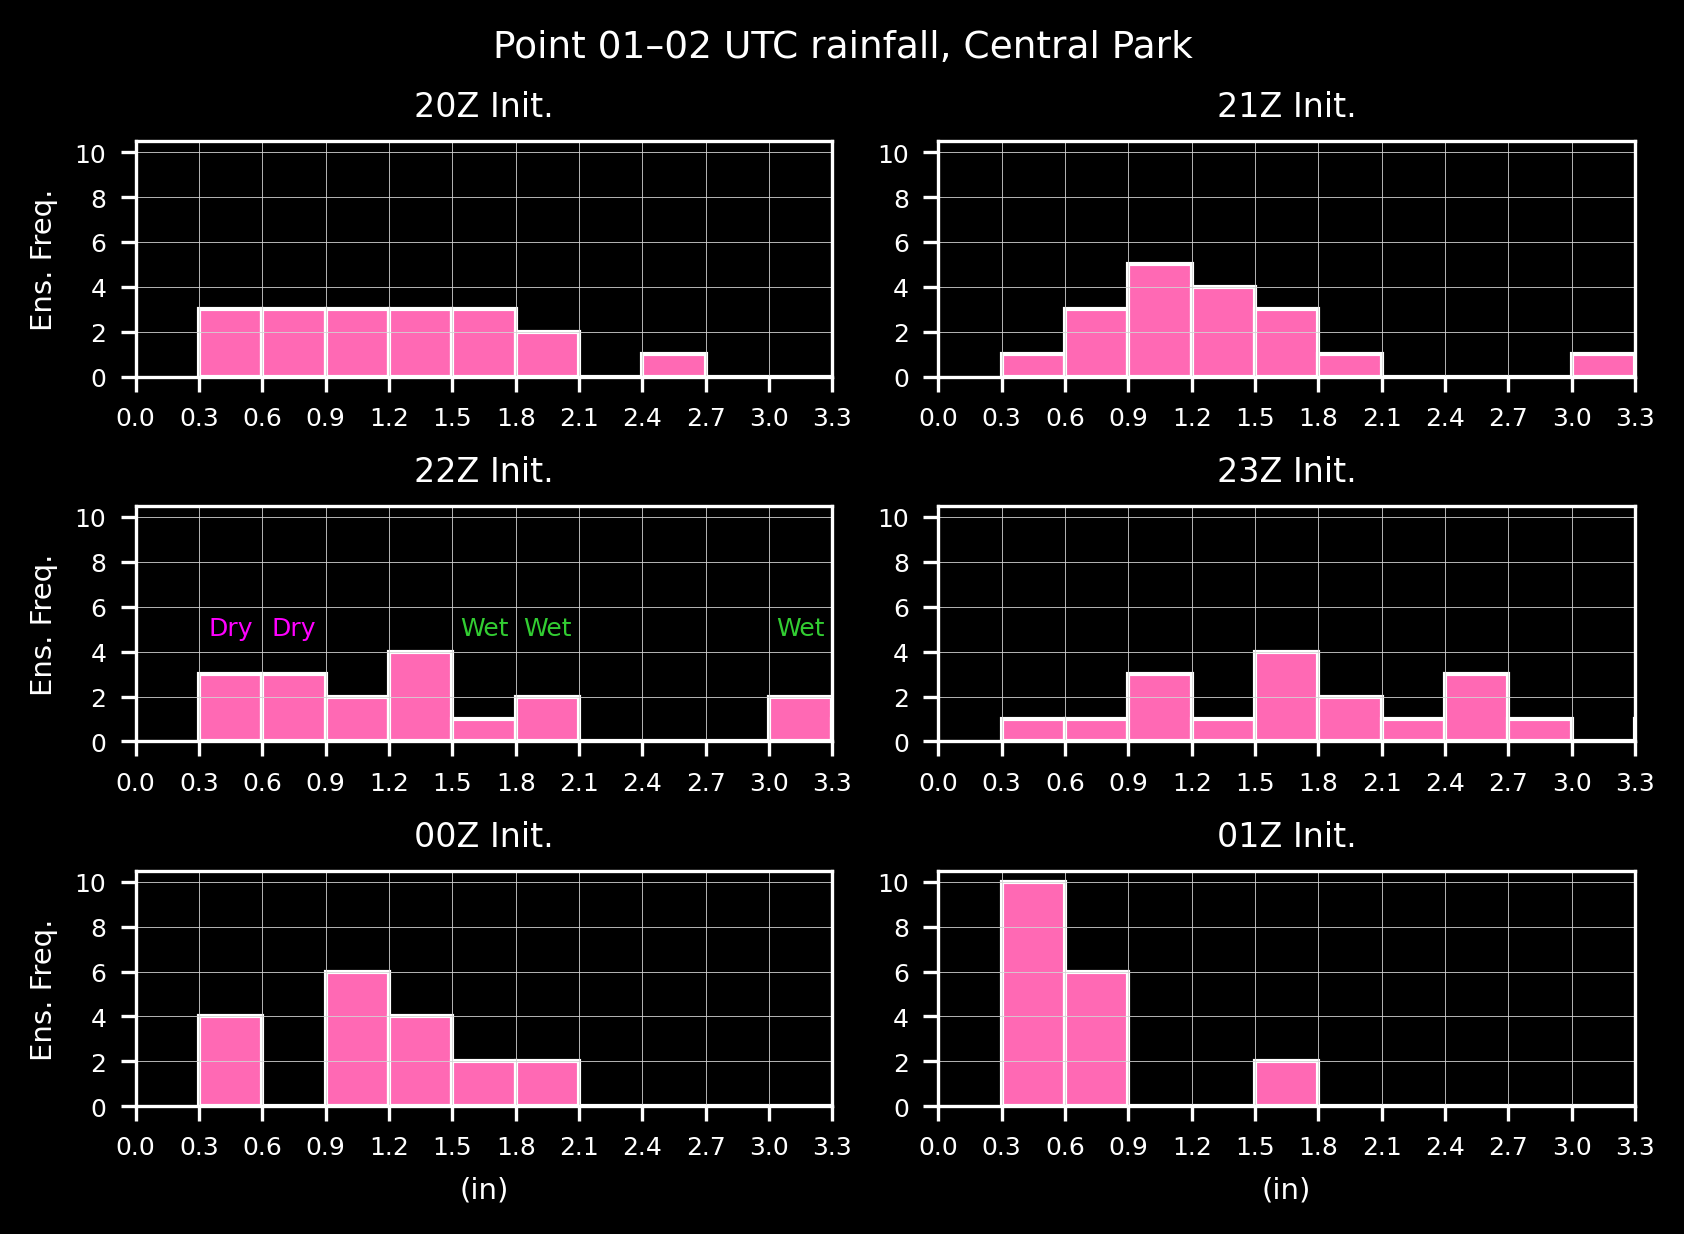

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use("dark_background")
bins = np.arange(0, 3.4, 0.3)

# Make a list of titles
titles = ["20Z Init.", "21Z Init.", "22Z Init.", "23Z Init.", "00Z Init.", "01Z Init."]

# Function to format the x-tick labels to two decimal points
def two_decimal_formatter(x, pos):
    return f"{x:.1f}"

# Make a 3 x 2 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    sharex=True,
    sharey=True,
    dpi=300,
    figsize=(5.5, 4),
    layout="constrained",
)

# Width for the bars in the histograms
bar_width = (bins[1] - bins[0]) / 1

# Loop through each initialization
for i, ax in enumerate(axes.flatten()):
    # Extract the data for the current initialization
    new_data = rain_0102_point.isel(init=i).values

    # Compute the histogram
    new_hist, _ = np.histogram(new_data, bins=bins)

    bars = ax.bar(
        bins[:-1] + bar_width,
        new_hist,
        width=bar_width,
        align="edge",
        edgecolor="white",
        color="hotpink",
        label="New WoFS",
    )

    # Highlight specified bins in the middle left plot
    if i == 2:  # Middle left plot
        wet_bins = [(3.0, 3.3), (1.8, 2.1), (1.5, 1.8)]
        dry_bins = [(0.3, 0.6), (0.6, 0.9)]
        
        for wet_bin in wet_bins:
            ax.text(
                (wet_bin[0] + wet_bin[1]) / 2,
                max(new_hist) + 0.5,
                'Wet',
                color='limegreen',
                ha='center',
                va='bottom',
                fontsize=6
            )

        for dry_bin in dry_bins:
            ax.text(
                (dry_bin[0] + dry_bin[1]) / 2,
                max(new_hist) + 0.5,
                'Dry',
                color='magenta',
                ha='center',
                va='bottom',
                fontsize=6
            )

    ax.xaxis.set_tick_params(which="both", labelbottom=True)
    ax.tick_params(axis="both", labelsize=6)
    ax.set_xticks(bins)
    ax.set_yticks(range(0, 12, 2))
    ax.yaxis.set_tick_params(which="both", labelleft=True)
    ax.grid(color="lightgray", linewidth=0.2)
    ax.set_title(titles[i], fontsize=8)
    ax.set_xlabel("")

    # Set the x-axis formatter to round to two decimal points
    ax.xaxis.set_major_formatter(FuncFormatter(two_decimal_formatter))

    if i % 2 == 0:
        ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set the x-axis labels for the bottom row of plots
axes[2, 1].set_xlabel("(in)", fontsize=7)
axes[2, 0].set_xlabel("(in)", fontsize=7)

# Set the x-axis limit
plt.xlim(bins.min(), bins.max())

# Set the overall title of the figure
plt.suptitle("Point 01–02 UTC rainfall, Central Park", fontsize=9)

# Show the plot
plt.show()


### Create Wet and Dry Ensembles

In [9]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain_0102_point
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain_0102_point
]

### NYC and area max rainfall

In [26]:
wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all)-1)]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all)-1)]

In [27]:
# Function to overwrite ne values
def overwrite_ne(da:xr.DataArray|xr.Dataset) -> xr.DataArray|xr.Dataset:
    da["ne"] = range(5)
    return(da)

In [30]:
# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z", "00Z"], dims="init")
init = init.assign_coords({"init": init})

rain_0102_wet = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_wet], dim=init)  # type:ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .max(dim=["lat", "lon"])
    .chunk("auto")
    .stack(run=("init", "ne"))
)
rain_0102_dry = (
    xr.concat([overwrite_ne(w.rain) for w in wofs_dry], dim=init)  # type: ignore
    .sel(time=slice("2021-09-02 01:05:00", "2021-09-02 02:00:00"))
    .sum(dim="time")
    .max(dim=["lat", "lon"])
    .chunk("auto")
    .stack(run=("init", "ne"))
)

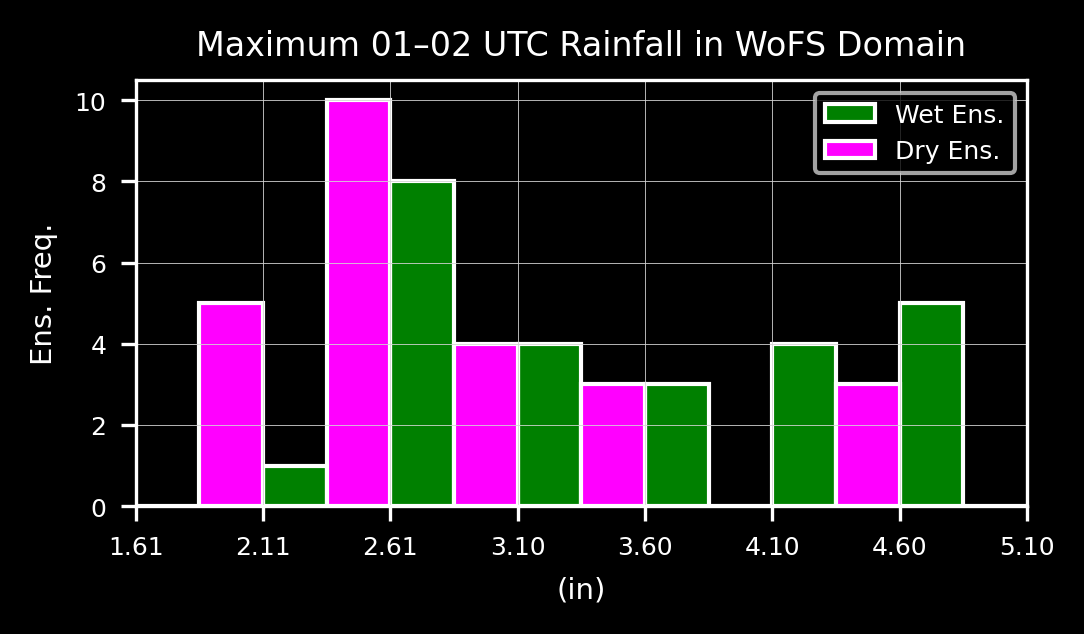

In [34]:
plt.style.use("dark_background")
bins = np.histogram_bin_edges(
    np.concat([rain_0102_wet.values, rain_0102_dry.values]), bins="auto"
)

# Make a list of titles
title = "Maximum 01–02 UTC Rainfall in WoFS Domain"

# Function to format the x-tick labels to two decimal points
def two_decimal_formatter(x, pos):
    return f"{x:.2f}"

# Make a 1 x 1 figure with a histogram of 1-2 UTC rainfall for each initialization
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=True,
    sharey=True,
    dpi=300,
    figsize=(3.5, 2),
    layout="constrained",
)

# Width for the bars in the histograms
bar_width = (bins[1] - bins[0]) / 2

# Extract the data for the current initialization
wet_data = rain_0102_wet.values
dry_data = rain_0102_dry.values

# Compute the histogram
wet_hist, _ = np.histogram(wet_data, bins=bins)
dry_hist, _ = np.histogram(dry_data, bins=bins)

# Plot the histograms
ax.bar(
    bins[:-1],
    wet_hist,
    width=bar_width,
    align="edge",
    edgecolor="white",
    color="green",
    label="Wet Ens.",
)
ax.bar(
    bins[:-1] + bar_width,
    dry_hist,
    width=bar_width,
    align="edge",
    edgecolor="white",
    color="magenta",
    label="Dry Ens.",
)

ax.xaxis.set_tick_params(which="both", labelbottom=True)
ax.tick_params(axis="both", labelsize=6)
ax.set_xticks(bins)
ax.set_yticks(range(0,12,2))
ax.yaxis.set_tick_params(which="both", labelleft=True)
ax.grid(color="lightgray", linewidth=0.2)
ax.set_title(title, fontsize=8)
ax.set_xlabel("")

# Set the x-axis formatter to round to two decimal points
ax.xaxis.set_major_formatter(FuncFormatter(two_decimal_formatter))

ax.set_ylabel("Ens. Freq.", fontsize=7)

# Set the x-axis labels for the bottom row of plots
ax.set_xlabel("(in)", fontsize=7)

# Set the x-axis limit
plt.xlim(bins.min(), bins.max())

# Add a legend to the plot
ax.legend(fontsize=6)

# Show the plot
plt.show()